In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.parallel.parallel_iterative_with_convexification import ParallelSensitivityBasedFW
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL

In [2]:
# Generate Data
d = 20
N = 1000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

In [3]:
print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (1000, 20)
mu: (20, 1)


In [4]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [5]:
def log_posterior(params, X, y, weights):
        return np.sum(log_likelihood(params, X, y, weights))

In [6]:
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

In [7]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

---

In [8]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

for i in range(90):
    sbfw = SensitivityBasedFW(x)
    psbfw = ParallelSensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = psbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

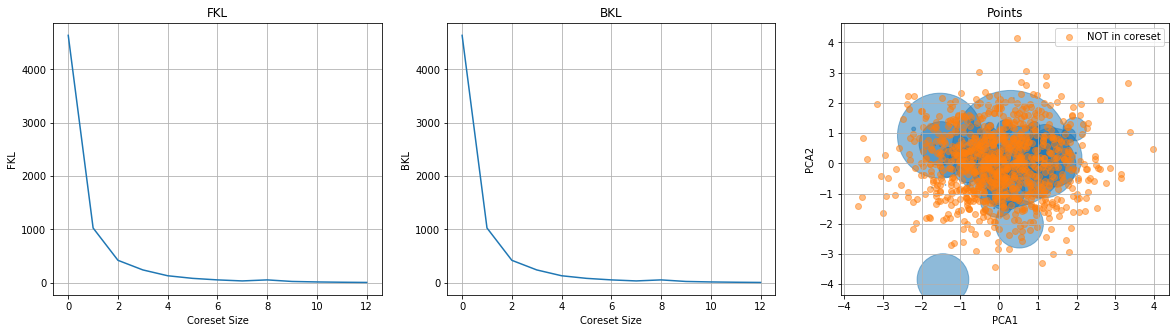

In [9]:
plot_results(fkl_p[::7], bkl_p[::7], x, I, w)

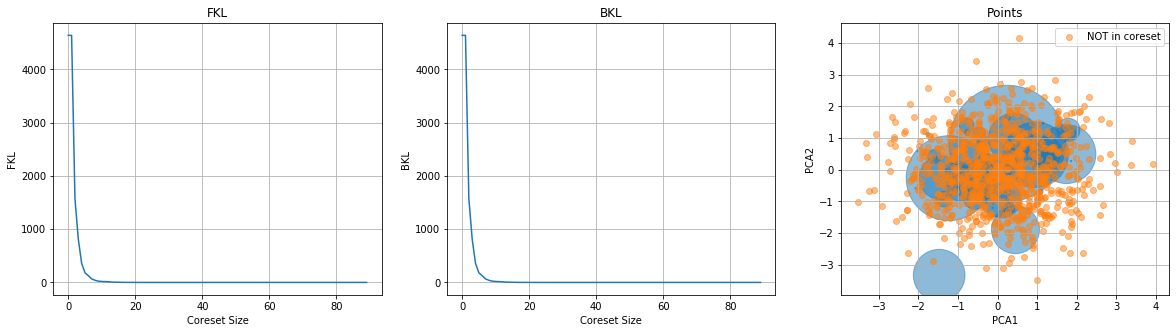

In [11]:
plot_results(fkl_s, bkl_s, x, I, w)

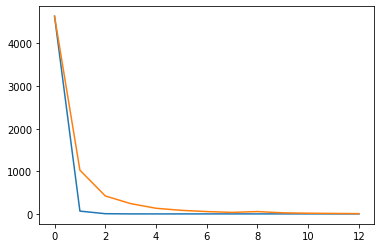

In [14]:
plt.plot(fkl_s[::7], label = 'Seq')
plt.plot(fkl_p[::7], label = 'Paral')

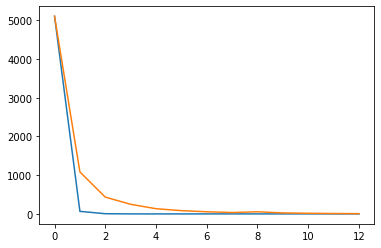

In [15]:
plt.plot(bkl_s[::7], label = 'Seq')
plt.plot(bkl_p[::7], label = 'Paral')